#Latest


In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k'
%ls

/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k
ablaptop_data.csv  read.csv             u1.base  u5.test  u.occupation
allbut.pl          README               u1.test  ua.base  userInfo.csv
cfgan.png          recall.png           u2.base  ua.test  userInfonew.csv
d_g_losses.png     Score_Regressor.png  u2.test  ub.base  u.user
itemInfo.csv       testdata.csv         u3.base  ub.test  u_user.user
mku.sh             test.txt             u3.test  u.data
ndgca.png          train.txt            u4.base  u.genre
precision.png      u10.base             u4.test  u.info
raw_data.csv       u10.test             u5.base  u.item


In [ ]:
from collections import defaultdict
import torch
import pandas as pd


def loadUseInfo(trainFile,splitMark):
    print(trainFile)
    UseInfo = pd.DataFrame(columns=["userId", "application", "laptop", "cpu", "gpu", "storage", "ram", "battery"])
    index = 0
    for line in open(trainFile):
        userId, application, laptop, cpu, gpu, storage, ram, battery = line.strip().split(splitMark)
        UseInfo.loc['%d'%index]=[userId, application, laptop, cpu, gpu, storage, ram, battery]
        index = index + 1
    UseInfo.to_csv("/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k/userInfonew.csv",index=False)
    print("Demographic information about the users loading done: %d users" % (index))
    return UseInfo

def loadTrainingData(trainFile,splitMark):
    #trainFile = path + "/" + benchmark + "/" + benchmark + ".train"
    print(trainFile)
    trainSet = defaultdict(list) 
    max_u_id = -1
    max_i_id = -1
    for line in open(trainFile):
        userId, itemId, rating,_ = line.strip().split(splitMark)
        userId = int(userId)
        itemId = int(itemId)
        # note that we regard all the observed ratings as implicit feedback
        trainSet[userId].append(itemId)
        max_u_id = max(userId, max_u_id)
        max_i_id = max(itemId, max_i_id)
    userCount = max_u_id + 1
    itemCount = max_i_id + 1
    print(userCount)
    print(itemCount)
    print("Training data loading done: %d users, %d items" % (userCount, itemCount))
    return trainSet, userCount, itemCount

def loadTestData(testFile,splitMark):
    #trainFile = path + "/" + benchmark + "/" + benchmark + ".train"
    print(testFile)
    testSet = defaultdict(list)
    max_u_id = -1
    max_i_id = -1
    for line in open(testFile):
        userId, itemId, rating,_ = line.strip().split(splitMark)
        userId = int(userId)
        itemId = int(itemId)
        testSet[userId].append(itemId)
        max_u_id = max(userId, max_u_id)
        max_i_id = max(itemId, max_i_id)
    userCount = max_u_id + 1
    itemCount = max_i_id + 1
    print(userCount)
    print(itemCount)
    print("Training data loading done: %d users, %d items" % (userCount, itemCount))
    return testSet,userCount,itemCount

def to_Vectors(trainSet, userCount, itemCount, userList_test, mode):
    # assume that the default is itemBased
    testMaskDict = defaultdict(lambda: [0] * itemCount)
    batchCount = userCount 
    if mode == "itemBased":
        userCount = itemCount
        itemCount = batchCount
        batchCount = userCount
    trainDict = defaultdict(lambda: [0] * itemCount)
    for userId, i_list in trainSet.items():
        for itemId in i_list:
            testMaskDict[userId][itemId] = -99999
            if mode == "userBased":
                trainDict[userId][itemId] = 1.0
            else:
                trainDict[itemId][userId] = 1.0

    trainVector = []
    for batchId in range(batchCount):
        trainVector.append(trainDict[batchId])

    testMaskVector = []
    for userId in userList_test:
        testMaskVector.append(testMaskDict[userId])
    print("Converting to vectors done....")
    return (torch.Tensor(trainVector)), torch.Tensor(testMaskVector), batchCount


In [ ]:
# -*- coding: utf-8 -*-

import torch
import torch.nn as nn
 
class discriminator(nn.Module):
    def __init__(self,itemCount,info_shape):
        super(discriminator,self).__init__()
        self.dis=nn.Sequential(
            nn.Linear(itemCount+info_shape,1024),
            nn.ReLU(True),
            nn.Linear(1024,128),
            nn.ReLU(True),
            nn.Linear(128,16),
            nn.ReLU(True),
            nn.Linear(16,1),
            nn.Sigmoid()
        )
    def forward(self,data,condition):
        data_c  = torch.cat((data,condition),1)
        result=self.dis( data_c )
        return result  
    
class generator(nn.Module):
    def __init__(self,itemCount,info_shape):
        self.itemCount = itemCount
        super(generator,self).__init__()
        self.gen=nn.Sequential(
            nn.Linear(self.itemCount+info_shape, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512,1024),
            nn.ReLU(True),
            nn.Linear(1024, itemCount),
            nn.Sigmoid()
        )
    def forward(self,noise,useInfo):
        G_input = torch.cat([noise, useInfo], 1)
        result=self.gen(G_input)
        return result

In [ ]:
import random
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn import preprocessing

#import data
#import cfgan

import warnings
warnings.filterwarnings("ignore")


def UseInfoPreprocessing(UseInfo):
    
    application_dummies = pd.get_dummies(UseInfo['application'])
    UseInfo = UseInfo.join(application_dummies)
    UseInfo.drop(['application'], axis=1, inplace=True)

    laptop_dummies = pd.get_dummies(UseInfo['laptop'])
    UseInfo = UseInfo.join(laptop_dummies)
    UseInfo.drop(['laptop'], axis=1, inplace=True)

    # create feature for the alphabetical part of the cpu
    UseInfo['cpuLetter'] = UseInfo['cpu'].map(lambda x: re.compile("(.+)").search(x).group())
    # convert the distinct cpu letters with incremental integer values
    UseInfo['cpuLetter'] = pd.factorize(UseInfo['cpuLetter'])[0]
    UseInfo[['cpu','cpuLetter']].head()
    UseInfo.drop(['cpu'], axis=1, inplace=True)

    # create feature for the alphabetical part of the gpu
    UseInfo['gpuLetter'] = UseInfo['gpu'].map(lambda x: re.compile("(.+)").search(x).group())
    # convert the distinct gpu letters with incremental integer values
    UseInfo['gpuLetter'] = pd.factorize(UseInfo['gpuLetter'])[0]
    UseInfo[['gpu','gpuLetter']].head()
    UseInfo.drop(['gpu'], axis=1, inplace=True)
    
    for i in UseInfo['storage']:
      try: 
        if int(UseInfo['storage'][i]):
          UseInfo['storage'][i] = str(UseInfo['storage'][i]) + 'GB'
      except: pass
    # create feature for the alphabetical part of the storage
    UseInfo['storageLetter'] = UseInfo['storage'].map(lambda x: re.compile("(.+)").search(x).group())
    # convert the distinct storage letters with incremental integer values
    UseInfo['storageLetter'] = pd.factorize(UseInfo['storageLetter'])[0]
    UseInfo[['storage','storageLetter']].head()
    UseInfo.drop(['storage'], axis=1, inplace=True)

    # create feature for the alphabetical part of the ram
    UseInfo['ramLetter'] = UseInfo['ram'].map(lambda x: re.compile("(.+)").search(x).group())
    # convert the distinct ram letters with incremental integer values
    UseInfo['ramLetter'] = pd.factorize(UseInfo['ramLetter'])[0]
    UseInfo[['ram','ramLetter']].head()
    UseInfo.drop(['ram'], axis=1, inplace=True)

    # create feature for the alphabetical part of the Battery
    UseInfo['batteryLetter'] = UseInfo['battery'].map(lambda x: re.compile("(.+)").search(x).group())
    # convert the distinct Battery letters with incremental integer values
    UseInfo['batteryLetter'] = pd.factorize(UseInfo['batteryLetter'])[0]
    UseInfo[['battery','batteryLetter']].head()
    UseInfo.drop(['battery'], axis=1, inplace=True)
    
    #UseInfo['useZipcodeLetter'] = UseInfo['useZipcode'].str.split().str[0]
    #UseInfo['useZipcodeLetter'] = UseInfo['useZipcodeLetter'].apply(lambda x: "99999" if not(x.isnumeric()) else x)
    #UseInfo['useZipcodeLetter'] = pd.factorize(UseInfo['useZipcodeLetter'])[0]
    #UseInfo[['useZipcode','useZipcodeLetter']].head()
    #UseInfo.drop(['useZipcode'], axis=1, inplace=True)

    # StandardScaler will subtract the mean from each value then scale to the unit varience
    #scaler = preprocessing.StandardScaler()
    #UseInfo['useAge_scaled'] = scaler.fit_transform(UseInfo['useAge'].values.reshape(-1,1))
    #UseInfo.drop(['useAge'], axis=1, inplace=True)
    
    return UseInfo


def select_negative_items(realData, num_pm, num_zr):
    '''
    realData : n-dimensional indicator vector specifying whether u has purchased each item i
    num_pm : num of negative items (partial-masking) sampled on the t-th iteration
    num_zr : num of negative items (zeroreconstruction regularization) sampled on the t-th iteration
    '''
    
    data = np.array(realData)
    n_items_pm = np.zeros_like(data)
    n_items_zr = np.zeros_like(data)
    for i in range(data.shape[0]):
        p_items = np.where(data[i] != 0)[0]
        all_item_index = random.sample(range(data.shape[1]), 198) #######
        for j in range(p_items.shape[0]):   
            all_item_index.remove(list(p_items)[j])
        random.shuffle(all_item_index)
        n_item_index_pm = all_item_index[0 : num_pm]
        n_item_index_zr = all_item_index[num_pm : (num_pm+num_zr)]
        n_items_pm[i][n_item_index_pm] = 1
        n_items_zr[i][n_item_index_zr] = 1
    
    return n_items_pm, n_items_zr


import math
def computeTopN(groundTruth,result,topN):
    #print(groundTruth)
    result=result.tolist()
    for i in range(len(result)):
        result[i]=(result[i],i)
    result.sort(key=lambda x:x[0],reverse=True)
    #print(result)
    hit=0
    dcg = 0
    idcg = 0
    idcgCount=len(groundTruth)
    for i in range(topN):
        if(result[i][1] in groundTruth):
            hit=hit+1
            dcg+=1/math.log2(i+2)
        if(idcgCount>0):
            idcg += 1/math.log2(i+2)
            idcgCount-=1
    return hit/topN,hit/len(groundTruth),dcg/idcg
    #computeTopNAccuracy(0,[1,2,5,9,100,-5,6,0],0)

def main(userCount,itemCount,testSet,trainVector,trainMaskVector,UseInfo_pre,topN,epochCount,pro_ZR,pro_PM,alpha):

    info_shape = UseInfo_pre.shape[1]
    UseInfo_pre = UseInfo_pre.values
    UseInfo_pre = np.insert(UseInfo_pre,0,[0]*286,axis=0)
    UseInfo_pre = torch.tensor(UseInfo_pre.astype(np.float32))
    result_precision=np.zeros((1,2))

    #result_precision=[]
    recallList=np.zeros((1,2))
    ndgcaList=np.zeros((1,2))
    
    # Build the generator and discriminator
    G=generator(itemCount, info_shape)
    D=discriminator(itemCount, info_shape)
    regularization = nn.MSELoss()
    d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)
    g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)
    G_step=5
    D_step=2
    batchSize_G = 32
    batchSize_D = 32
    
    for epoch in range(epochCount): 
        
        # ---------------------
        #  Train Generator
        # ---------------------
        
        for step in range(G_step):
            
            # Select a random batch of purchased vector
            leftIndex = random.randint(1, userCount - batchSize_G - 1)
            realData = Variable(copy.deepcopy(trainVector[leftIndex:leftIndex + batchSize_G]))
            eu = Variable(copy.deepcopy(trainVector[leftIndex:leftIndex + batchSize_G]))
            useInfo_batch = Variable(copy.deepcopy(UseInfo_pre[leftIndex:leftIndex + batchSize_G]))
            
            # Select a random batch of negative items for every user
            n_items_pm,n_items_zr = select_negative_items(realData,pro_PM,pro_ZR)           
            ku_zp = Variable(torch.tensor(n_items_pm + n_items_zr))
            realData_zp = Variable(torch.ones_like(realData)) * eu + Variable(torch.zeros_like(realData)) * ku_zp
            
            # Generate a batch of new purchased vector
            fakeData=G(realData,useInfo_batch) 
            fakeData_ZP = fakeData * (eu + ku_zp)  
            fakeData_result=D(fakeData_ZP,useInfo_batch) 
            
            # Train the discriminator
            g_loss = np.mean(np.log(1.-fakeData_result.detach().numpy()+10e-5))  + alpha*regularization(fakeData_ZP,realData_zp)
            g_optimizer.zero_grad()
            g_loss.backward(retain_graph=True)
            g_optimizer.step()
            
        # ---------------------
        #  Train Discriminator
        # ---------------------
        for step in range(D_step):
            # Select a random batch of purchased vector
            leftIndex=random.randint(1,userCount-batchSize_D-1)
            realData=Variable(copy.deepcopy(trainVector[leftIndex:leftIndex+batchSize_D])) 
            eu = Variable(copy.deepcopy(trainVector[leftIndex:leftIndex + batchSize_G]))
            useInfo_batch = Variable(copy.deepcopy(UseInfo_pre[leftIndex:leftIndex + batchSize_G]))
            
            # Select a random batch of negative items for every user
            n_items_pm, _ = select_negative_items(realData,pro_PM,pro_ZR)
            ku = Variable(torch.tensor(n_items_pm))
            
            # Generate a batch of new purchased vector
            fakeData=G(realData,useInfo_batch) 
            fakeData_ZP = fakeData * (eu + ku)
            
            # Train the discriminator
            fakeData_result=D(fakeData_ZP,useInfo_batch) 
            realData_result=D(realData,useInfo_batch) 
            d_loss = -np.mean(np.log(realData_result.detach().numpy()+10e-5) + 
                              np.log(1. - fakeData_result.detach().numpy()+10e-5)) + 0*regularization(fakeData_ZP,realData_zp)
            d_optimizer.zero_grad()
            d_loss.backward(retain_graph=True)
            d_optimizer.step()
            
        if( epoch%1==0):
            n_user=len(testSet)
            
            index=0
            precisions=0
            recalls=0
            ndgcas=0
            for testUser in testSet.keys():

                data = Variable(copy.deepcopy(trainVector[testUser]))
                useInfo_index = Variable(copy.deepcopy(torch.tensor(np.expand_dims(UseInfo_pre[index], axis=0))))
                #  Exclude the purchased vector that have occurred in the training set
                result = G(data.reshape(1,198),useInfo_index) + Variable(copy.deepcopy(trainMaskVector[index]))
                result = result.reshape(198)
                
                precision, recall, ndgca = computeTopN(testSet[testUser], result, topN)
                precisions+=precision
                recalls+=recall
                ndgcas+=ndgca
                index+=1
                
            precisions = precisions/n_user
            recalls = recalls/n_user
            ndgcas = ndgcas/n_user
            #print(recalls)

            result_precision=np.concatenate((result_precision,np.array([[epoch,precisions]])),axis = 0)
            #result_precision.append(precisions)
            recallList=np.concatenate((recallList,np.array([[epoch,recalls]])),axis = 0) #.append(recalls)
            ndgcaList=np.concatenate((ndgcaList,np.array([[epoch,ndgcas]])),axis = 0) #.append(ndgcas)

            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f},precision:{},recall:{},ndgca:{}'.format(epoch, epochCount,
            d_loss.item(),
            g_loss.item(),
            precisions, recalls, ndgcas))

    return result_precision, recallList , ndgcaList

def result_plt(result_precision, recallList, ndgcaList):
    plt.title("CFGAN")
    plt.xlabel('epoch')
    #plt.ylabel('')
    #plt.plot(result_precision[:,0], result_precision[:,1], "r-*",label='precision' )
    plt.plot(recallList[:,0], recallList[:,1], "k-*", color='red', label='recall', markersize='0')
    plt.plot(result_precision[:,0], result_precision[:,1], "r-*",color='black',label='precision',markersize =  '0' )#List,List,List

    plt.plot(ndgcaList[:,0], ndgcaList[:,1], "k-o", color='green', label='ndcg', markersize =  '0')
    plt.ylim([0, 0.2])
    plt.legend()  
    #plt.rcParams['lines.linewidth'] = 1
    plt.show()

if __name__ == '__main__':
    
    topN=5
    epochs = 1000
    pro_ZR = 50
    pro_PM = 50
    alpha = 0.1
    UseInfo = loadUseInfo("/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k/u_user.user", "|")
#    ItemInfo = data.loadItemInfo("data/ml-100k/u.item"  , "|")
    UseInfo_pre = UseInfoPreprocessing(UseInfo)
    UseInfo_pre.drop(['userId'], axis=1, inplace=True)
    trainSet,train_use,train_item = loadTrainingData("/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k/u10.base", "|")
    testSet,test_use,test_item = loadTestData("/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k/u10.test", "|")
    userCount = max(train_use,test_use)
    itemCount = max(train_item,test_item)
    userList_test = list(testSet.keys())
    trainVector, trainMaskVector, batchCount = to_Vectors(trainSet, userCount,itemCount, userList_test, "userBased")

    result_precision, recallList, ndcgList = main(userCount,itemCount,testSet,trainVector,trainMaskVector,UseInfo_pre,topN,epochs,pro_ZR,pro_PM,alpha)
    result_precision = result_precision[1:,]
    recallList = recallList[1:,]
    ndgcaList = ndcgList[1:,]
    


/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k/u_user.user
Demographic information about the users loading done: 3557 users
/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k/u10.base
83
197
Training data loading done: 83 users, 197 items
/content/gdrive/MyDrive/Colab Notebooks/data/ml-100k/u10.test
83
198
Training data loading done: 83 users, 198 items
Converting to vectors done....
Epoch[0/1000],d_loss:1.394230,g_loss:-0.785108,precision:0.06486486486486487,recall:0.018909851409851408,ndgca:0.06089355357324244
Epoch[1/1000],d_loss:1.396413,g_loss:-0.786005,precision:0.05675675675675676,recall:0.013019188019188022,ndgca:0.05355439675104712
Epoch[2/1000],d_loss:1.395980,g_loss:-0.787103,precision:0.05675675675675676,recall:0.010407160407160408,ndgca:0.05166448380542443
Epoch[3/1000],d_loss:1.394802,g_loss:-0.781497,precision:0.04864864864864866,recall:0.008337233337233336,ndgca:0.0427967940425179
Epoch[4/1000],d_loss:1.396110,g_loss:-0.789575,precision:0.05675675675675676,recal

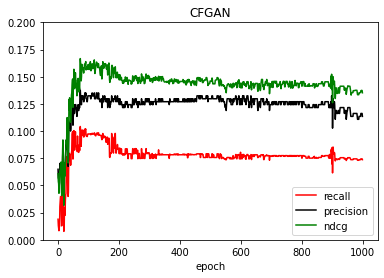

In [ ]:
result_plt(result_precision, recallList, ndgcaList)

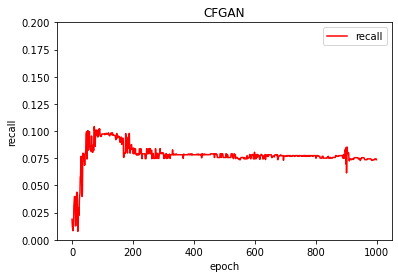

In [ ]:
def result_plt1(recallList):
    plt.title("CFGAN")
    plt.xlabel('epoch')
    plt.ylabel('recall')
    #plt.ylabel('')
    #plt.plot(result_precision[:,0], result_precision[:,1], "r-*",label='precision' )
    plt.plot(recallList[:,0], recallList[:,1], "k-*", color='red', label='recall', markersize='0')
    plt.ylim([0, 0.2])
    plt.legend()  
    #plt.rcParams['lines.linewidth'] = 1
    plt.savefig("recall.png")
    plt.show()
result_plt1(recallList)

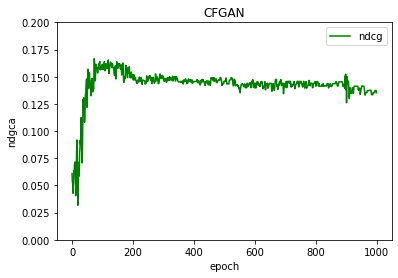

In [ ]:
def result_plt2(ndgcaList):
    plt.title("CFGAN")
    plt.xlabel('epoch')
    plt.ylabel('ndgca')
    #plt.ylabel('')
    plt.plot(ndgcaList[:,0], ndgcaList[:,1], "k-o", color='green', label='ndcg', markersize =  '0')
    plt.ylim([0, 0.2])
    plt.legend()  
    #plt.rcParams['lines.linewidth'] = 1
    plt.savefig("ndgca.png")
    plt.show()
result_plt2(ndgcaList)

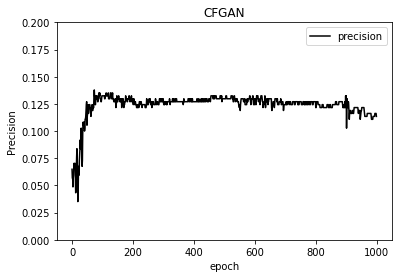

In [ ]:
def result_plt3(result_precision):
    plt.title("CFGAN")
    plt.xlabel('epoch')
    plt.ylabel('Precision')
    #plt.ylabel('')
    plt.plot(result_precision[:,0], result_precision[:,1], "r-*",color='black',label='precision',markersize =  '0' )#List,List,List
    plt.ylim([0, 0.2])
    plt.legend()  
    #plt.rcParams['lines.linewidth'] = 1
    plt.savefig("precision.png")
    plt.show()
result_plt3(result_precision)

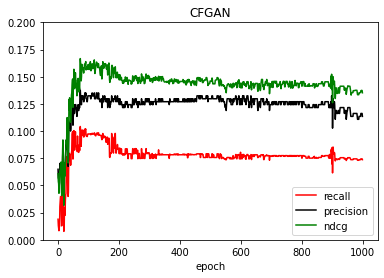

In [ ]:
def result_plt4(result_precision, recallList, ndgcaList):
    plt.title("CFGAN")
    plt.xlabel('epoch')
    #plt.ylabel('')
    #plt.plot(result_precision[:,0], result_precision[:,1], "r-*",label='precision' )
    plt.plot(recallList[:,0], recallList[:,1], "k-*", color='red', label='recall', markersize='0')
    plt.plot(result_precision[:,0], result_precision[:,1], "r-*",color='black',label='precision',markersize =  '0' )#List,List,List

    plt.plot(ndgcaList[:,0], ndgcaList[:,1], "k-o", color='green', label='ndcg', markersize =  '0')
    plt.ylim([0, 0.2])
    plt.legend()  
    #plt.rcParams['lines.linewidth'] = 1
    plt.savefig("cfgan.png")
    plt.show()
result_plt4(result_precision, recallList, ndgcaList)

In [ ]:
result_precision

array([[0.00000000e+00, 1.02702703e-01],
       [1.00000000e+00, 8.37837838e-02],
       [2.00000000e+00, 8.64864865e-02],
       ...,
       [9.97000000e+02, 1.27027027e-01],
       [9.98000000e+02, 1.27027027e-01],
       [9.99000000e+02, 1.27027027e-01]])

In [ ]:
testSet

defaultdict(list,
            {0: [42, 40],
             1: [40, 42],
             2: [141, 140, 63, 150, 87, 155, 42, 40, 39],
             3: [141, 140, 82, 150, 63, 64, 164, 146, 87, 155, 77, 42, 39],
             4: [141, 140, 82, 150, 63, 64, 164, 146, 87, 155, 77, 42, 39],
             5: [141, 64, 63, 155, 42, 40, 39],
             6: [141, 63, 64, 155, 42, 40, 39],
             7: [141, 63, 64, 155, 40, 42, 39],
             8: [141, 63, 64, 155, 40, 42, 39],
             9: [141, 140, 82, 146, 145, 39, 167, 53, 53, 51],
             10: [140, 82, 164, 146, 145, 53, 53, 51],
             11: [140, 82, 164, 146, 145, 39, 53, 53, 51],
             12: [141,
              140,
              82,
              190,
              11,
              185,
              191,
              189,
              64,
              63,
              150,
              164,
              75,
              14,
              13,
              108,
              197,
              102,
            